# ConditionalWaveNet

## Preparations

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/My\ Drive/Project-X/colab/src

/content/drive/My Drive/Project-X/colab/src


In [ ]:
! git clone https://github.com/Studienarbeit-Konrad-Hendrik/ConditionalWaveNetModel.git .

Cloning into '.'...


## Actual Code

### Data Preparation

In [2]:
import torch

In [16]:
test_data_x = []
test_data_y = []
test_data_hl = []

batch_size = 10
num_batches = 10
sample_length = 5000

for i in range(num_batches):
  data_x = (torch.rand((batch_size, 1, sample_length)) * 2 - 1) * 2**15
  data_y = torch.cat([data_x[:, :, 1:], torch.rand((batch_size, 1, 1))], dim=2)

  data_hl = torch.rand((batch_size, 1, sample_length))

  test_data_x.append(data_x)
  test_data_y.append(data_y)
  test_data_hl.append(data_hl)


Scale down from 16bit PCM

In [17]:
scaled_data_y = []
scaled_data_x = []

max_scale = 2**15

for b in range(num_batches):
  scaled_data_y.append(test_data_y[b] / max_scale)
  scaled_data_x.append(test_data_x[b] / max_scale)



In [18]:
def mu_transform(data_in, mu=255):
  in_bounds = torch.sign(data_in) * (torch.log(mu * torch.abs(data_in) + 1) / torch.log(torch.tensor(1 + mu, dtype=torch.float)))
  return (in_bounds * (((mu + 1) // 2) - 1) + 128).long()


In [19]:
def mu_transform_inverted(data_in, mu=255):
  data_scaled = (data_in - 128) / ((mu + 1) // 2 - 1)
  return torch.sign(data_scaled) * torch.tensor(1 / mu) * (torch.pow(torch.tensor(1 + mu, dtype=torch.float), torch.abs(data_scaled)) - 1)

In [20]:
mu_tranformed_y = []
for b in range(num_batches):
  mu_tranformed_y.append(mu_transform(scaled_data_y[b]).reshape((batch_size, sample_length)))

In [21]:
mu_tranformed_y[7].max()

tensor(254)

### Model loading and initialization

In [9]:
import ConditionalWaveNetModel as cw
import imp
imp.reload(cw)

<module 'ConditionalWaveNetModel' from '/content/drive/My Drive/Project-X/colab/src/ConditionalWaveNetModel.py'>

In [22]:
device = torch.device("cuda")
model = cw.ConditionalWaveNet(has_local_cond=False, has_global_cond=False).to(device)

### Training

In [23]:
import torch.nn as nn
import torch.optim as optim

In [24]:
epochs = 500
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
for e in range(epochs):
  avg_loss = 0.0
  for b in range(num_batches):
    x_data = scaled_data_x[b].cuda()
    y_data = mu_tranformed_y[b].cuda()
    hl_data = test_data_hl[b].cuda()

    model.zero_grad()

    out_data, skip_sum = model.foot(x_data, y=hl_data)
    pred_data = model.head(skip_sum)

    loss = loss_f(pred_data, y_data)
    loss.backward()
    optimizer.step()

    avg_loss += loss
  avg_loss /= num_batches

  print(e, avg_loss)


0 tensor(5.5425, device='cuda:0', grad_fn=<DivBackward0>)
1 tensor(5.5308, device='cuda:0', grad_fn=<DivBackward0>)
2 tensor(5.5303, device='cuda:0', grad_fn=<DivBackward0>)
3 tensor(5.5303, device='cuda:0', grad_fn=<DivBackward0>)
4 tensor(5.5303, device='cuda:0', grad_fn=<DivBackward0>)
5 tensor(5.5303, device='cuda:0', grad_fn=<DivBackward0>)
6 tensor(5.5295, device='cuda:0', grad_fn=<DivBackward0>)
7 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
8 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
9 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
10 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
11 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
12 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
13 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
14 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
15 tensor(5.5287, device='cuda:0', grad_fn=<DivBackward0>)
16 tensor(5.5288, device='cuda:0', grad_fn=<DivBackward0>)
17 tens

In [ ]:
import torchsummary

In [ ]:
torchsummary.summary(model, [(1, 5000), (1,5000)], batch_size=16)

torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 96, 5000])
torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 96, 5000])
torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 96, 5000])
torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 96, 5000])
torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 96, 5000])
torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 128, 5000])
torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 128, 5000])
torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 128, 5000])
torch.Size([2, 64, 5000]) torch.Size([2, 64, 5000]) torch.Size([2, 128, 5000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     ConstantPad1d-1              [16, 1, 5001]               0
            Conv1d-2             [16, 64, 5000]             192
     ConstantPad1d-3             [16,

In [ ]:
import hiddenlayer

/content/drive/My Drive/Project-X/colab/src/ConditionalWaveNetModel.py:179: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  print(data_in.shape, l_mult_scaled.shape, l_mult.shape)


torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 96, 5000])
torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 96, 5000])
torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 96, 5000])
torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 96, 5000])
torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 96, 5000])
torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 128, 5000])
torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 128, 5000])
torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 128, 5000])
torch.Size([16, 64, 5000]) torch.Size([16, 64, 5000]) torch.Size([16, 128, 5000])


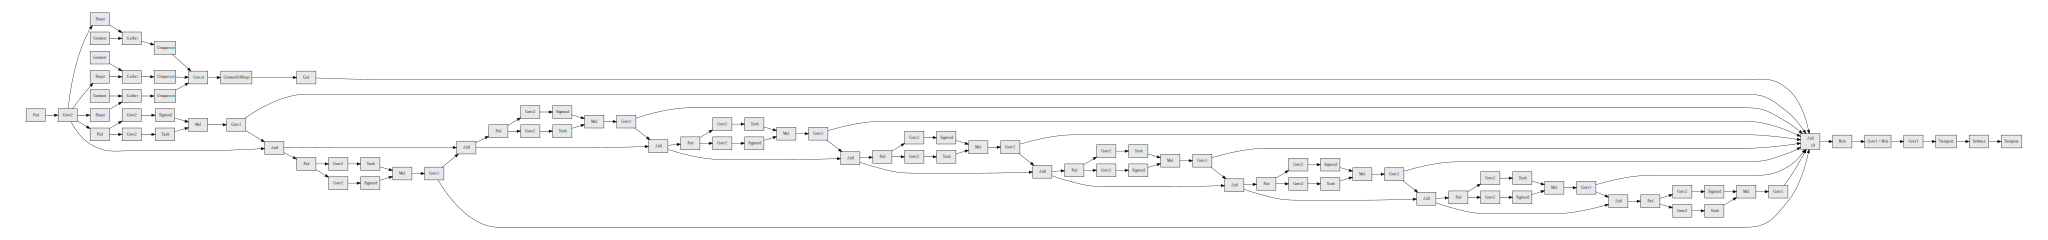

In [ ]:
g = hiddenlayer.build_graph(model, torch.zeros([16, 1, 5000]).cuda())
g

In [ ]:
g.save("network_graph.svg")

In [ ]:
!git add Cond*